In [37]:
# mounting drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# install packages

!pip install tensorflow-gpu
!pip install keras-tuner
!pip install tabulate

In [39]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten
import kerastuner


In [40]:
# load dataset

df = pd.read_csv("/content/drive/MyDrive/FYP Dataset/January Data/Victoria Centre STH (JAN).csv")

In [41]:
# converting date format into YY-mm-dd HH:MM:SS

df['DateTime'] = pd.to_datetime(df['status.parkingRecord.parkingRecordStatus.parkingOccupancy.vehicleCountAndRate.measurementTimeDefault'], format="%Y-%m-%dT%H:%M:%S.%fZ")

In [42]:
# extracting features before training

import time
from datetime import datetime

df['Date'] = pd.to_datetime(df['DateTime']).dt.date
df['Hour'] = pd.to_datetime(df['DateTime']).dt.hour
df['Minute'] = pd.to_datetime(df['DateTime']).dt.minute

df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.dayofweek

df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month


In [43]:
#split data into train and test set
from sklearn.model_selection import train_test_split

X = df[['Day',
        'Weekday',
        'Hour',
        'Minute']]
y = df[['status.parkingRecord.parkingRecordStatus.parkingOccupancy.parkingOccupancy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [44]:
#summary statistics of feature

train_stats = X_train.describe()
train_stats = train_stats.transpose()

In [45]:
# normalise data

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(X_train)
normed_test_data = norm(X_test)

In [46]:
# ANN model architecture with hyperparameter tuning

def build_model(hp):
  model = keras.models.Sequential()

  model.add(Dense(hp.Int("input_units", 16, 256, 16), input_shape = [len(X.keys())]))
  model.add(Activation('relu'))

  for i in range(hp.Int("layers", 2, 6)):
    model.add(Dense(hp.Int(f"conv_{i}_units", 16, 256, 16)))
    model.add(Activation('relu'))

  model.add(Dense(1))
  
  model.compile(optimizer=tf.keras.optimizers.RMSprop(hp.Choice('learning_rate', values = [0.01, 0.001, 0.0001])), loss = "mse", metrics = ["mae", "mse"])

  return model

In [47]:
# hyperparameter tuning

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = RandomSearch(
    build_model,
    objective = "mse",
    max_trials = 2,
    executions_per_trial = 3
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [48]:
# early stopping
 
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience = 10)

In [49]:
# Start training

tuner.search(x = normed_train_data, # training input
             y = y_train,       # training label
             epochs = 200,      # set epoch
             batch_size=64,     # set batch size
             validation_data=(normed_test_data, y_test),  # validation data
             callbacks = [early_stopping])    #early stopping function

Trial 2 Complete [00h 00m 13s]
mse: 56.7587636311849

Best mse So Far: 56.7587636311849
Total elapsed time: 00h 00m 31s
INFO:tensorflow:Oracle triggered exit


In [50]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_units: 16
layers: 5
conv_0_units: 240
conv_1_units: 176
learning_rate: 0.01
conv_2_units: 144
conv_3_units: 160
conv_4_units: 16
Score: 56.7587636311849
Trial summary
Hyperparameters:
input_units: 112
layers: 4
conv_0_units: 64
conv_1_units: 240
learning_rate: 0.01
conv_2_units: 16
conv_3_units: 16
Score: 59.66673151652018


In [51]:
# get best model
best_model = tuner.get_best_models()[0]

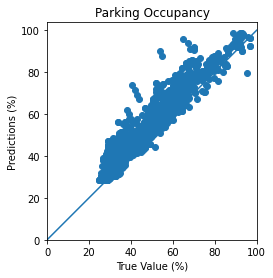

In [52]:
# plot graph of Prediction value against True value

import matplotlib.pyplot as plt

test_predictions = best_model.predict(normed_test_data)

plt.scatter(y_test, test_predictions)
plt.title('Parking Occupancy')
plt.xlabel('True Value (%)')
plt.ylabel('Predictions (%)')
plt.axis('equal')
plt.axis('square')
plt.xlim( [0,plt.xlim()[1]])
plt.ylim( [0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
 
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Model Validation/Victoria Centre STH.jpg")

In [53]:
# show metrics

from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

MSE = mean_squared_error(y_test, test_predictions)
RMSE = np.sqrt(mean_squared_error(y_test, test_predictions))
MAE = mean_absolute_error(y_test, test_predictions)

print(tabulate([["MSE",MSE],["RMSE",RMSE], ["MAE", MAE]]))


----  --------
MSE   27.6703
RMSE   5.26026
MAE    4.01688
----  --------


In [54]:
# save model

best_model.save('/content/drive/MyDrive/Colab Notebooks/V4/Victoria Centre STH.h5')